This notebook will develop a function to read wideband frequency response output from Echoview and adjust the frequency bins to resample at a given frequency range points.

In [1]:
import csv
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
%matplotlib inline

# Write function to read file

In [2]:
def read_widebandfrequencyresponse(fname,header = 0, extracols = 1, source='Echoview'):
    """"Opens a file created by the wideband frequency response graph 
    export file. Returns a matrix containing the frequency array and 
    the volume backscattering coefficient.
    
    Parameters:
    fname: filename with path of EV export from wideband frequency response plot - graph- export
    header: the number of lines in the header information (the default is 9.)
    extracols: The columns without backscatter information. Typically information on fileset. (The default is 1.)
    source: File export program. LSSS or Echoview (default)
    
    Returns:
    freqs: array of frequencies
    sv: array of volume backscatter coefficient values
    sv_mean: mean of the volume backscatter coefficient values across all frequencies (consider changing to median)
    sv_std: standard deviation of the data (consider changing to SE)
    """
    if source=='Echoview':
        wideband_extract = pd.read_csv(fname, header=0, index_col = 0)
        data = wideband_extract.T

        # Extract time
        times = np.array([])
        ntimes = len(data.index)-2
        for ind in range(0,ntimes):
            times = np.append(times, datetime.strptime('%s %s' %(data['Ping_date'][ind],data['Ping_time'][ind]), '%Y-%m-%d %H:%M:%S'))

        # Extract sv and frequencies
        Sv_resp = data.to_numpy()[:-2,8:]
        Sv_resp_array = np.array(Sv_resp, dtype=float)

        #Calculate volume backscatter coefficient.
        freqs = np.array(data.columns[8:], dtype=float)
        sv = 10**(Sv_resp_array/10)
        
        # calculate mean and std
        sv_mean = np.mean(sv,0)
        sv_std = np.std(sv,0)
        
    if source=='LSSS':
        times = []
        json_file = open(fname)
        freq_response_lsss = json.load(json_file)
        ping_lsss = freq_response_lsss['regions'][0]['pings']
        
        # Set up frequency array
        min_freq = ping_lsss[0]['channels'][0]['minFrequency']
        max_freq = ping_lsss[0]['channels'][0]['maxFrequency']
        num_freqs = ping_lsss[0]['channels'][0]['numFrequencies']
        freqs = np.linspace(min_freq,max_freq,num_freqs)
        Sv = np.zeros([len(freqs), len(ping_lsss)])
        for ind in range(0,len(ping_lsss)):
            Sv[:,ind]=ping_lsss[ind]['channels'][0]['sv']
        sv = 10**(Sv/10)
        sv_mean = np.mean(sv,1)
        sv_std = np.std(sv,1)
        

    
    return freqs, sv, sv_mean, sv_std, times

## Run function Echoviw export

In [3]:
fname = 'D:/GLIDER2018/Echosounder/Flaket_SSL/Wideband_210618_830.csv'
freqs, sv, sv_mean, sv_std, times = read_widebandfrequencyresponse(fname, extracols = 2)

### Plot

Text(0, 0.5, 'sv ($m_{-1}$)')

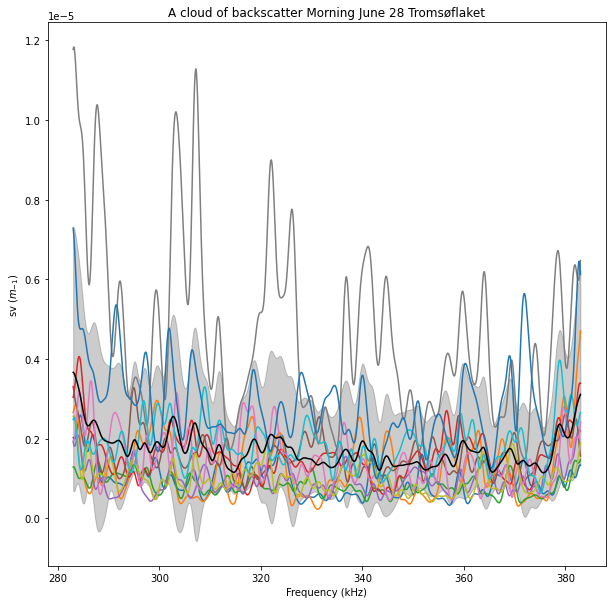

In [4]:
fig=plt.figure(figsize=(10, 10),facecolor='w', edgecolor='k')
plt.plot(freqs,sv.T)
plt.plot(freqs,sv_mean, 'k')
plt.fill_between(freqs,sv_mean-sv_std, sv_mean+sv_mean, color='k', alpha=0.2)
plt.title('A cloud of backscatter Morning June 28 Tromsøflaket')
plt.xlabel('Frequency (kHz)')
plt.ylabel('sv ($m_{-1}$)')

## Run function LSSS function

In [5]:
fname = 'D:/GLIDER2018/Echosounder/LSSS_Tromsøflaket/Export/BroadbandSv/BroadbandSv_T20180628_07062004-20180628_12060909_01.json'
freqs, sv, sv_mean, sv_std, times = read_widebandfrequencyresponse(fname, source='LSSS')

Text(0, 0.5, 'sv ($m_{-1}$)')

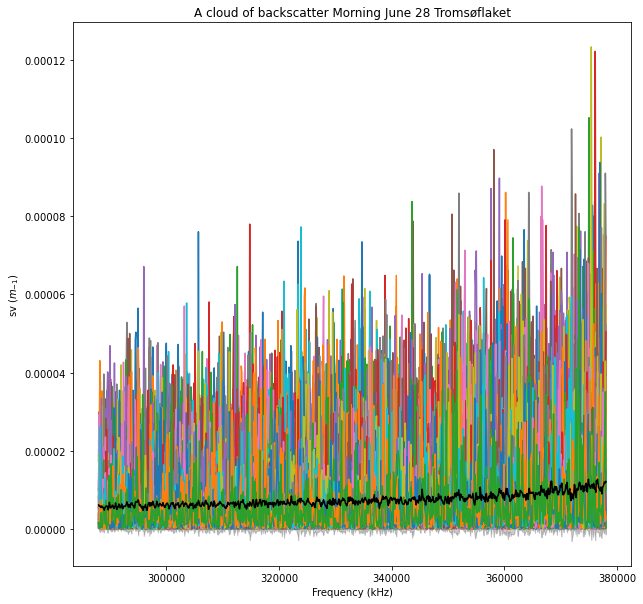

In [6]:
fig=plt.figure(figsize=(10, 10),facecolor='w', edgecolor='k')
plt.plot(freqs,sv)
plt.plot(freqs,sv_mean, 'k')
plt.fill_between(freqs,sv_mean-sv_std, sv_mean+sv_mean, color='k', alpha=0.2)
plt.title('A cloud of backscatter Morning June 28 Tromsøflaket')
plt.xlabel('Frequency (kHz)')
plt.ylabel('sv ($m_{-1}$)')